<a href="https://colab.research.google.com/github/Namtk214/AIO-Homework/blob/main/LeNet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LENET MODEL WITH MNIST DATASET


In [3]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time



In [4]:
ROOT = './data'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 348kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.78MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

# create loader

BATCH_SIZE = 256
train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)


In [6]:
# LeNet

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)

        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)

        outputs = self.flatten(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        outputs = self.fc3(outputs)
        return outputs

In [7]:
# training function
def train(model, train_dataloader, optimizer, criterion, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()
    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)

        #Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        #Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f} | loss {:8.3f}'.format(
                epoch, idx, len(train_dataloader),
                total_acc/total_count, np.mean(losses)))
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

# Evaluation function
def evaluate(model, valid_dataloader, criterion, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

In [8]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters())

num_epochs = 10
train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    #training
    train_acc, train_loss = train(lenet_model, train_dataloader, optimizer, criterion, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    #Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, valid_dataloader, criterion, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    #Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(), 'lenet_model.pt')

    print('-'*59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | train loss {:8.3f}' '| Valid accuracy {:8.3f} | Valid loss {:8.3f}'.format(
        epoch, time.time()-epoch_start_time, train_acc, train_loss, eval_acc, eval_loss))
    print('-'*59)

    # Load best model
    lenet_model.load_state_dict(torch.load('lenet_model.pt'))
    lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.662 | loss    1.214
| epoch   1 |   100/  211 batches | accuracy    0.886 | loss    0.803
| epoch   1 |   150/  211 batches | accuracy    0.910 | loss    0.637
| epoch   1 |   200/  211 batches | accuracy    0.930 | loss    0.537
-----------------------------------------------------------
| end of epoch   1 | time: 14.41s | train accuracy    0.936 | train loss    0.521| Valid accuracy    0.943 | Valid loss    0.184
-----------------------------------------------------------


<ipython-input-8-0dea734b4e5a>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load('lenet_model.pt'))


| epoch   2 |    50/  211 batches | accuracy    0.948 | loss    0.165
| epoch   2 |   100/  211 batches | accuracy    0.961 | loss    0.147
| epoch   2 |   150/  211 batches | accuracy    0.964 | loss    0.138
| epoch   2 |   200/  211 batches | accuracy    0.968 | loss    0.131
-----------------------------------------------------------
| end of epoch   2 | time: 12.94s | train accuracy    0.971 | train loss    0.129| Valid accuracy    0.968 | Valid loss    0.105
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.971 | loss    0.093
| epoch   3 |   100/  211 batches | accuracy    0.974 | loss    0.091
| epoch   3 |   150/  211 batches | accuracy    0.972 | loss    0.090
| epoch   3 |   200/  211 batches | accuracy    0.976 | loss    0.088
-----------------------------------------------------------
| end of epoch   3 | time: 12.84s | train accuracy    0.974 | train loss    0.087| Valid accuracy    0.975 | Valid loss    0.084
--

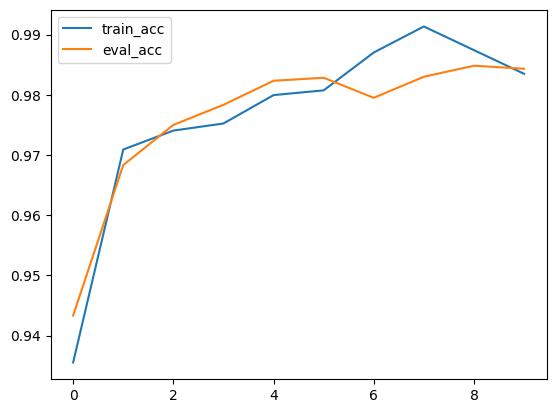

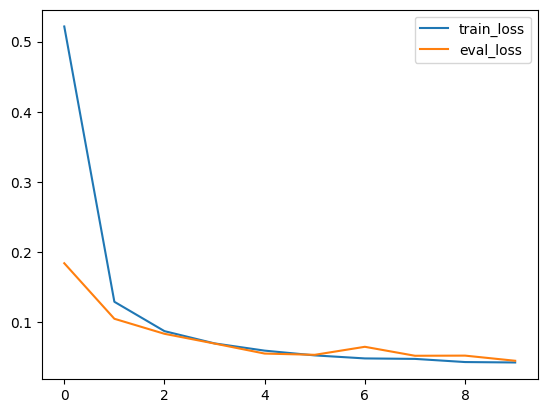

In [9]:
plt.plot(train_accs, label='train_acc')
plt.plot(eval_accs, label='eval_acc')
plt.legend()
plt.show()

plt.plot(train_losses, label='train_loss')
plt.plot(eval_losses, label='eval_loss')
plt.legend()
plt.show()

In [10]:
test_data.transform = test_transforms
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

test_acc, test_loss = evaluate(lenet_model, test_dataloader, criterion, device)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

Test accuracy: 0.9885
Test loss: 0.034640242153545844


CASSAVA LEAF DATASET DISEASE DATASET

In [11]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \-O /content/cassavaleafdata.zip
!unzip /content/cassavaleafdata.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
 

In [18]:
data_paths = {
    'train': '/content/cassavaleafdata/train',
    'valid': '/content/cassavaleafdata/validation',
    'test': '/content/cassavaleafdata/test'
}

#load image from path
def loader(path):
    return Image.open(path)

img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),])

train_data = datasets.ImageFolder(root=data_paths['train'], transform=train_transforms)
valid_data = datasets.ImageFolder(root=data_paths['valid'], transform=train_transforms)
test_data = datasets.ImageFolder(root=data_paths['test'], transform=train_transforms)

In [19]:
# LeNet
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=16*35*35, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)

        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)

        outputs = self.flatten(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        outputs = self.fc3(outputs)
        return outputs

In [20]:
# training function
def train(model, train_dataloader, optimizer, criterion, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()
    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)

        #Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        #Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f} | loss {:8.3f}'.format(
                epoch, idx, len(train_dataloader),
                total_acc/total_count, np.mean(losses)))
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

# Evaluation function
def evaluate(model, valid_dataloader, criterion, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

In [21]:
# create loader

BATCH_SIZE = 256
train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [25]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=2e-4)

num_epochs = 10
save_model = './model'
train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    #training
    train_acc, train_loss = train(lenet_model, train_dataloader, optimizer, criterion, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    #Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, valid_dataloader, criterion, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    #Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(),save_model + 'lenet_model.pt')

    print('-'*59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | train loss {:8.3f}' '| Valid accuracy {:8.3f} | Valid loss {:8.3f}'.format(
        epoch, time.time()-epoch_start_time, train_acc, train_loss, eval_acc, eval_loss))
    print('-'*59)

    # Load best model
    #lenet_model.load_state_dict(torch.load('lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   23 batches | accuracy    0.435 | loss    1.409
| epoch   1 |    20/   23 batches | accuracy    0.471 | loss    1.383
-----------------------------------------------------------
| end of epoch   1 | time: 47.41s | train accuracy    0.546 | train loss    1.380| Valid accuracy    0.487 | Valid loss    1.428
-----------------------------------------------------------
| epoch   2 |    10/   23 batches | accuracy    0.483 | loss    1.315
| epoch   2 |    20/   23 batches | accuracy    0.483 | loss    1.318
-----------------------------------------------------------
| end of epoch   2 | time: 47.47s | train accuracy    0.425 | train loss    1.321| Valid accuracy    0.484 | Valid loss    1.416
-----------------------------------------------------------
| epoch   3 |    10/   23 batches | accuracy    0.496 | loss    1.285
| epoch   3 |    20/   23 batches | accuracy    0.489 | loss    1.280
-----------------------------------------------------------
| end of epoch   3 | t

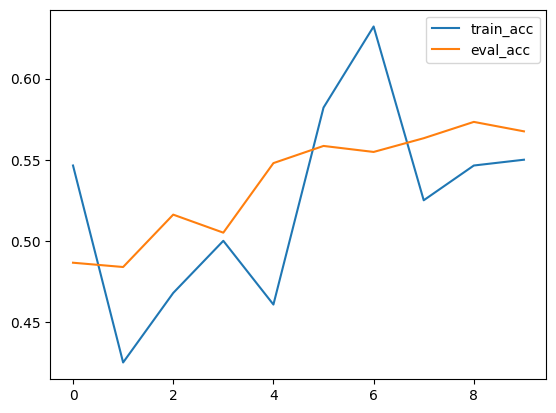

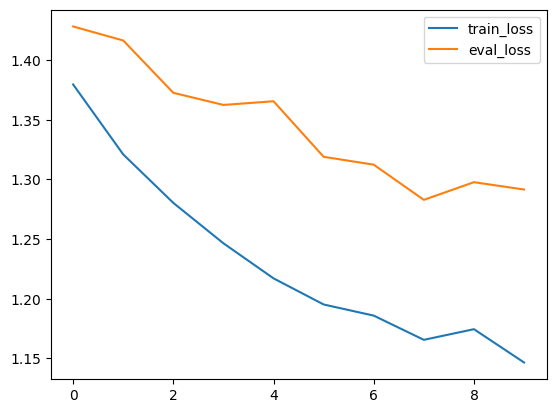

In [26]:
plt.plot(train_accs, label='train_acc')
plt.plot(eval_accs, label='eval_acc')
plt.legend()
plt.show()

plt.plot(train_losses, label='train_loss')
plt.plot(eval_losses, label='eval_loss')
plt.legend()
plt.show()

In [27]:
test_acc, test_loss = evaluate(lenet_model, test_loader, criterion, device)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

Test accuracy: 0.579840848806366
Test loss: 1.2726951986551285


TEXT CLASSIFICATION

In [29]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31

In [43]:
import os
import pandas as pd

def load_data_from_path(folder_path):
  examples = []
  for label in os.listdir(folder_path):
    full_path = os.path.join(folder_path, label)
    for file_name in os.listdir(full_path):
      file_path = os.path.join(full_path, file_name)
      with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
      sentence = ' '.join(lines)
      if label == 'neg':
        label = 0
      else:
        label = 1
      data = {
          'sentence': sentence,
          'label': label
      }
      examples.append(data)
  return pd.DataFrame(examples)


In [46]:
folder_paths = {
    'train': './data/data_train/train',
    'test': './data/data_train/test',
    'valid': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
test_df = load_data_from_path(folder_paths['test'])
valid_df = load_data_from_path(folder_paths['valid'])

In [47]:
train_df

,sentence,label
0,Đi 2 lần r lần đầu kím đường muốn chết tới nơi...,0
1,"Ở gần nhà nên cũng ghé qua ăn 2,3 lần . Quán c...",1
2,"Ta ̀ u hu ̉ cư ̣ c dơ ̉ , nha ̣ t nhe ̃ o lă ́...",1
3,Đô ̀ ăn k qua ́ dơ ̉ nhưng cu ̃ ng chưa ngon :...,1
4,Được bạn_bè giới_thiệu về phong_cách trang_trí...,1
...,...,...
29995,"Về cơ_bản thì quán này chẳng lạ_lùng gì mấy , ...",1
29996,Quán mới mở hồi tháng 11-12 . Các món ăn đều n...,1
29997,Đồ_ăn ngon đừng hỏi luôn 😍 😍 😍\n Mình là ng th...,1
29998,Quán không_gian dễ_thương . Các đồ uống rất ng...,1


In [36]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=2ba89a46137fb98d8b7aa890e042592cc394e1e2e9338a56de267915b174ee7a
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [49]:
from langid.langid import LanguageIdentifier, model
def identify_vn(df):
  identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
  not_vi_idx = set()
  THRESHOLD = 0.9
  for idx, row in df.iterrows():
    score = identifier.classify(row['sentence'])
    if score[0] != 'vi' or (score[0] == 'vi' and score[1] <= THRESHOLD):
      not_vi_idx.add(idx)
  vi_df = df[df.index.isin(not_vi_idx)]
  not_vi_df = df[df.index.isin(not_vi_idx)]
  return vi_df, not_vi_df

train_df_vi, train_df_other = identify_vn(train_df)

In [50]:
import re
import string

def preprocess_text(text):
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    emoji_pattern = re.compile(
        "[" +
        u"\U0001F600-\U0001F64F" +  # emoticons
        u"\U0001F300-\U0001F5FF" +  # symbols & pictographs
        u"\U0001F680-\U0001F6FF" +  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" +  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4" +  # Macau flag
        u"\U0001F1E6-\U0001F1FF" +  # flags
        u"\U0001F600-\U0001F64F" +
        u"\U00002702-\U000027B0" +
        u"\U000024C2-\U0001F251" +
        u"\U0001f926-\U0001f937" +
        u"\U0001F1F2" +
        u"\U0001F1F4" +
        u"\U0001F620" +
        u"\u200d" +
        u"\u2640-\u2642" +
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    return text.lower()

train_df_vi['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()
]
valid_df['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in valid_df.iterrows()
]
test_df['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in test_df.iterrows()
]


<ipython-input-50-af624209e348>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [


In [52]:
# Install torchtext
!pip install --upgrade torch torchvision torchaudio
!pip install --upgrade torchtext==0.16.0
# Word-based tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# Create iterator dataset
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# Build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

# Convert iterator into torchtext dataset
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.m

OSError: /usr/local/lib/python3.10/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN2at4_ops5zeros4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEE

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    # Create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)


In [ ]:
class TextCNN(nn.module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_filters, kernel_sizes):
        super().__init__(TextCNN, self).__init__():
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=kernel_size
            ) for kernel_size in kernel_sizes
        ])
        self.fc = nn.Linear(
            in_features=len(kernel_sizes) * num_filters,
            out_features=num_classes
        )

        def forward(self, inputs):
            batch_size, sequence_length = x.shape
            x = self.embedding(x.T).transpose(1, 2)
            x = [F.relu(conv(x)) for conv in self.conv]
            x = [F.adaptive_avg_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
            x = torch.cat(x, dim=1)
            x = self.fc(x)
            return x

In [ ]:
# Training
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero gradient
        optimizer.zero_grad()

        # Predictions
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward
        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

# Evaluation
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Predictions
            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [ ]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=num_class
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end of epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f} s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

# Load best model
model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
model.eval()


In [ ]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_acc, test_loss = evaluate(model, criterion, test_dataloader, device)
test_acc, test_loss
